# Chart ideas

In [24]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import warnings
warnings.simplefilter('ignore')

Some example data from JPMAQS

In [2]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
cids_m = ['AUD', 'CAD', 'THB', 'ZAR']
cats_m = ['CABUSDBN', 'NFDIUSDBN']
dfm = dbi.get_series_values(category=cats_m, cross_section=cids_m, frequency="m")  # import grade 1 vintages
dfm['ticker'] = dfm[['cross_section', 'category_code', 'adjustment']].agg('_'.join, axis=1)  # add ticker column

cids_d = ['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'KRW', 'INR', 'JPY', 'MXN', 'NZD', 'TRY', 'ZAR']
cats_d = ['FXXRUSD', 'FXCRYUSD']
dfd = dbi.get_series_values(category=cats_d, cross_section=cids_d, frequency="d")  # daily non-vintage data
dfd['ticker'] = dfd[['cross_section', 'category_code', 'adjustment']].agg('_'.join, axis=1)  # add ticker column

## Data availability graphics

Count simply the number of data points

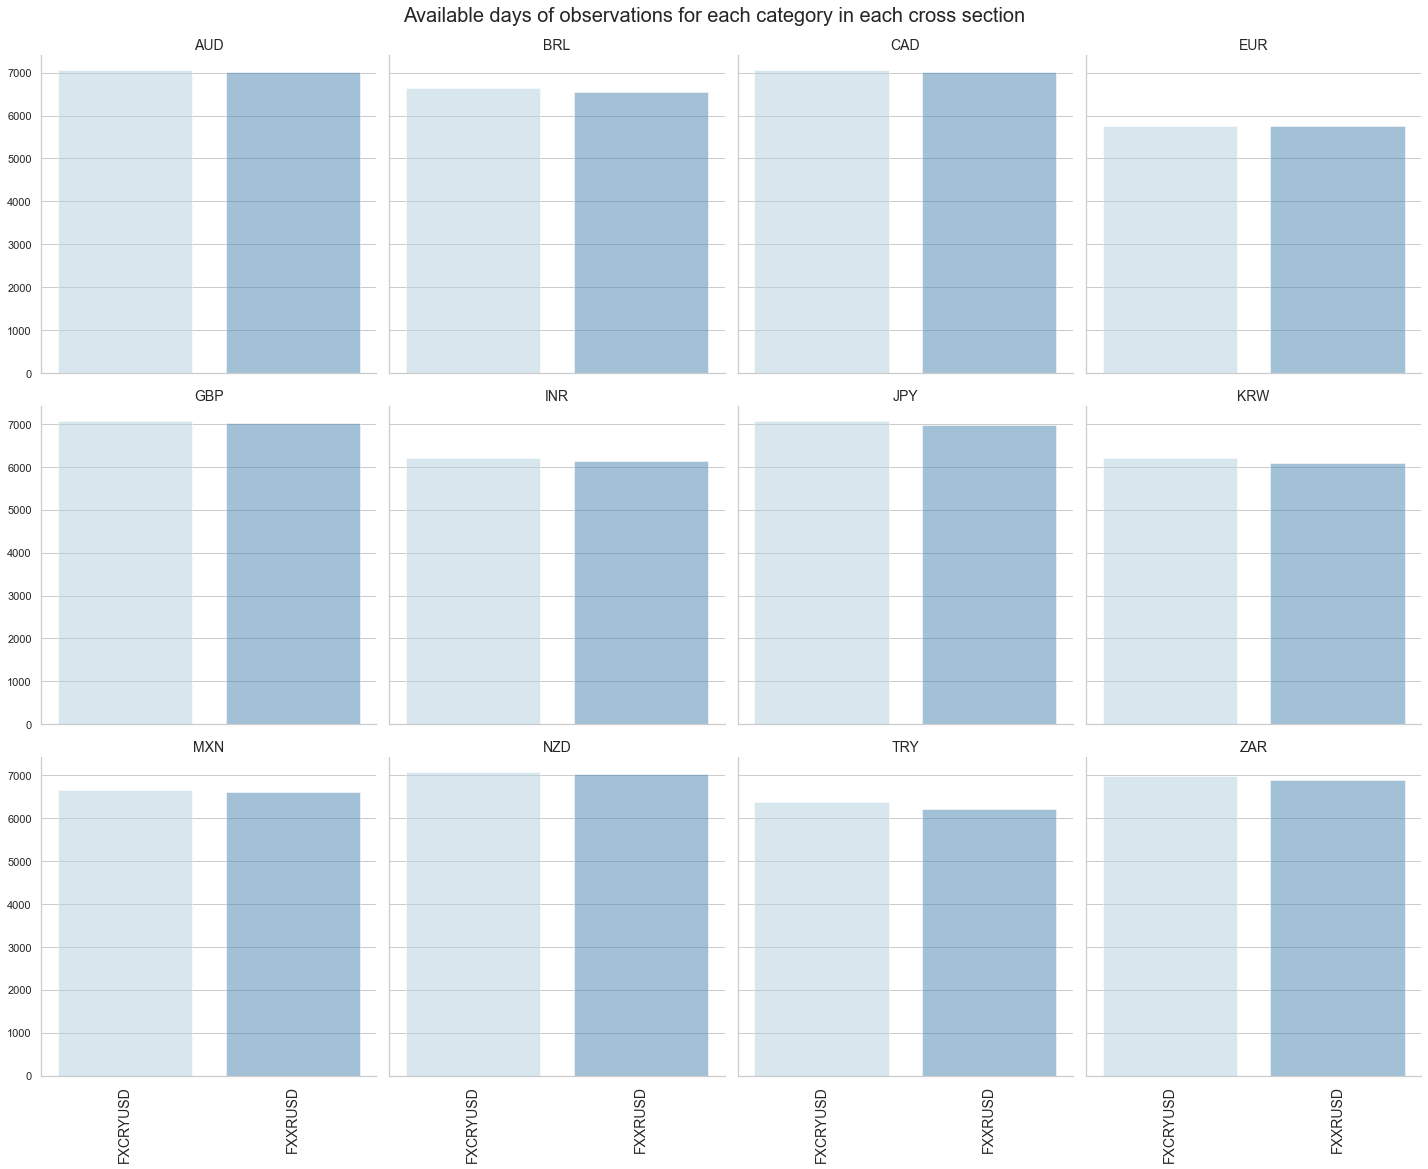

In [3]:
sns.set_theme(style='whitegrid')
f = sns.catplot(data=dfd, kind='count', x='category_code', 
                col='cross_section', col_wrap=4, col_order=np.sort(dfd['cross_section'].unique()),
                palette='Blues', alpha=0.5)
f.set_xticklabels(rotation=90, size=14)

(f.set_axis_labels("", "")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Available days of observations for each category in each cross section', y=1.02, size=20))

plt.show()

Visualize data availability across years of particular category

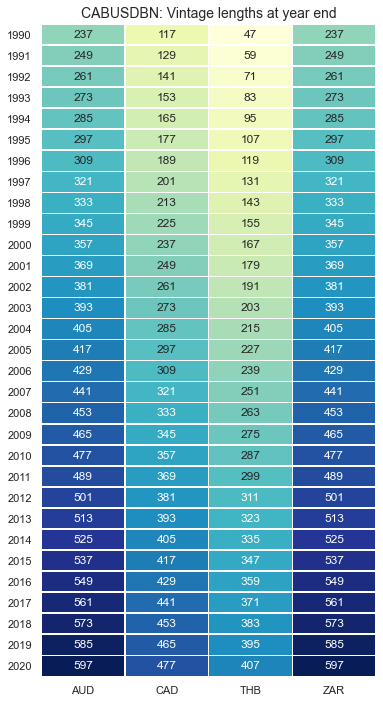

In [7]:
cat = 'CABUSDBN'
dfx = dfm[dfm['category_code']==cat]
xids = np.sort(dfx['cross_section'].unique())
dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
dfx = dfx[dfx.year > 1989]

dfxx = pd.DataFrame(columns=dfx.columns)
for cid in xids:
    dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
    releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
    dfcx = dfc[dfc['release_date'].isin(releases)]
    dfxx = dfxx.append(dfcx)

count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
fig, ax = plt.subplots(figsize=(6, 12))
sns.heatmap(count_matrix, annot=True, fmt="d",
                cmap="YlGnBu", cbar=False, linewidths=.5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(cat + ': Vintage lengths at year end', y = 1.1, fontsize=14)

plt.show()

Vintage observation counts across time and ticker

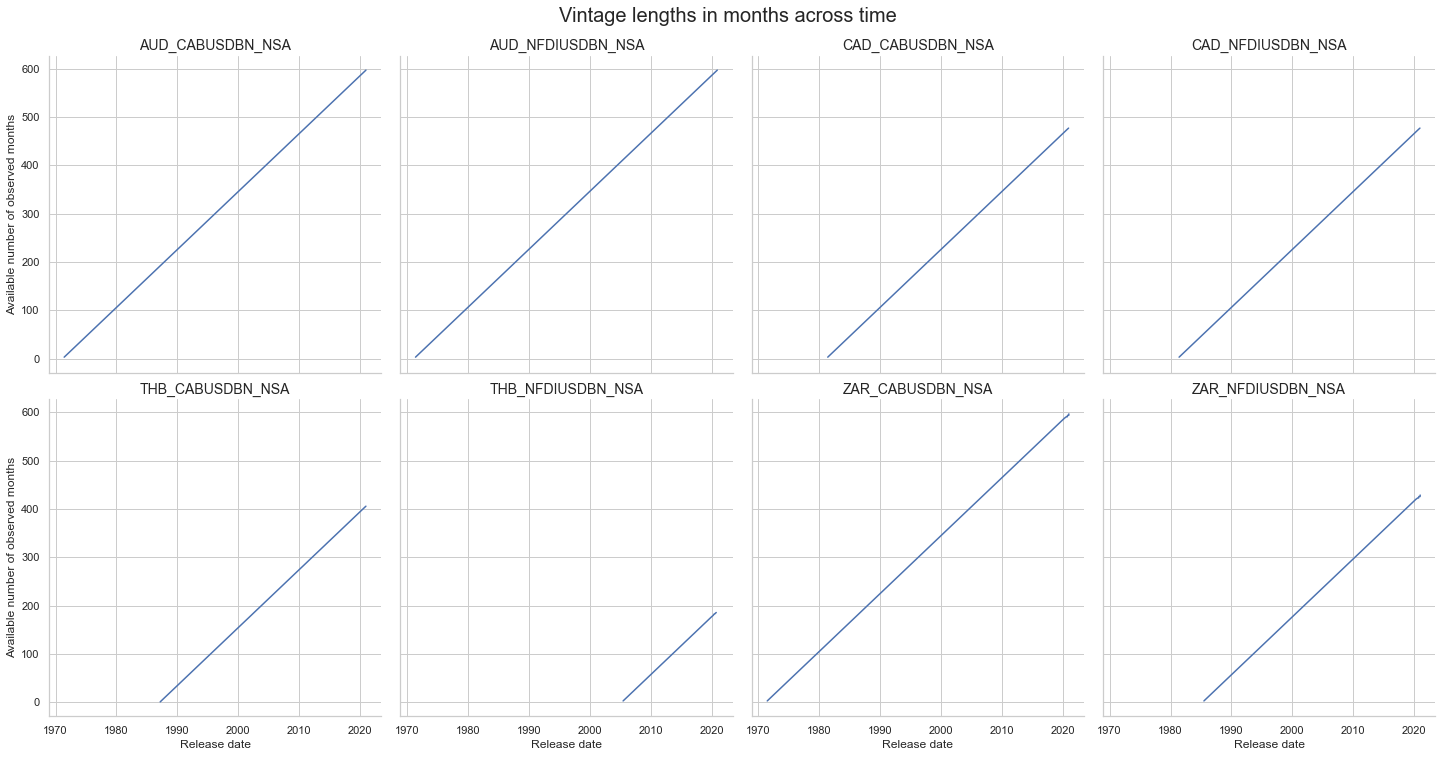

In [4]:
dfm_x = dfm.loc[:, ['ticker', 'release_date', 'observation_date']].groupby(['ticker', 'release_date']).agg('count')
dfm_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='ticker', col_wrap=4)
(f.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

Same as above, but with two-dimensional facet grid

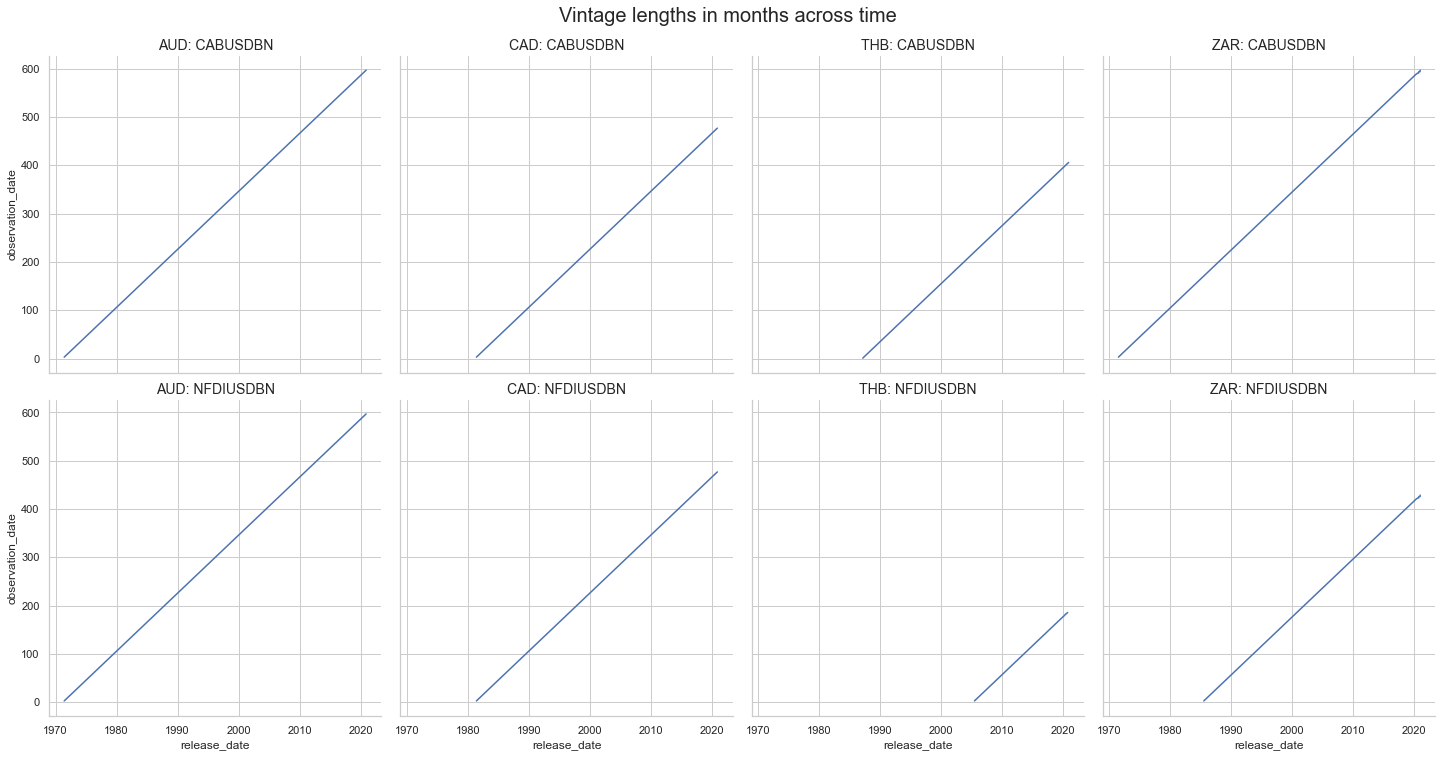

In [5]:
dfm_x = (dfm.loc[:, ['cross_section', 'category_code', 'release_date', 'observation_date']]
         .groupby(['cross_section', 'category_code', 'release_date']).agg('count'))
dfm_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', 
                col='cross_section', row='category_code')
(f.set_titles("{col_name}: {row_name}", size=14)
   .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

## Revision graphics

Vintages over several release dates

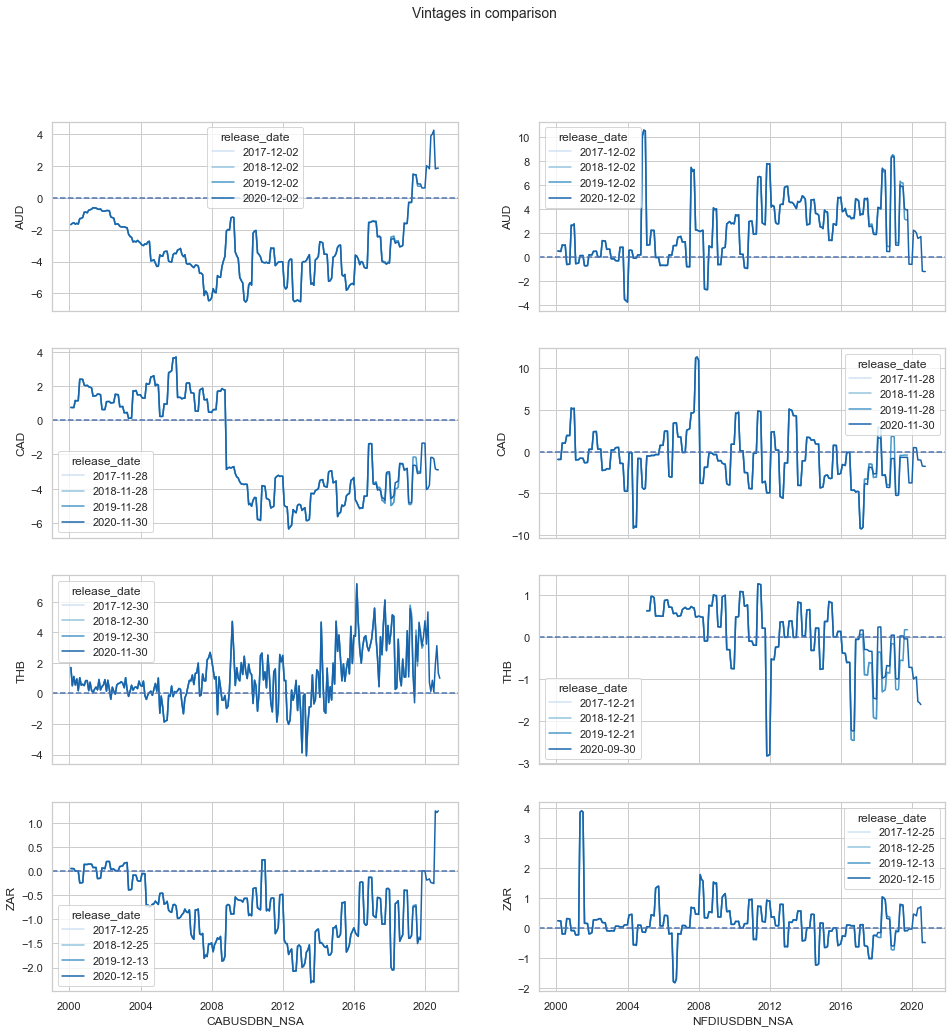

In [62]:
cids = ['AUD', 'CAD', 'THB', 'ZAR']
tiks = ['CABUSDBN_NSA', 'NFDIUSDBN_NSA']
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

dfm_x = dfm[dfm['observation_date'] > pd.to_datetime('2000-01-01')]  # reduce relevant history

sns.set_style('whitegrid')
colors = sns.color_palette("Blues", len(pots))
fig, axes = plt.subplots(nrows=len(cids), ncols=len(tiks), sharex=True, figsize=(16, 16))

for cid in cids:
    for tik in tiks:
        ticker = cid + '_' + tik
        dfm_xx = dfm_x.query('ticker == @ticker')
        releases = dfm_xx['release_date'].unique()
        selected_releases = [None] * len(pots)
        for i in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[i]))].max()
            selected_releases[i] = release
        dfm_xxx = dfm_xx[dfm_xx['release_date'].isin(selected_releases)]  # filter out releases
        axe = axes[cids.index(cid), tiks.index(tik)]
        sns.lineplot(data=dfm_xxx,  x="observation_date", y="value", 
                     hue="release_date", palette=colors, ax=axe)
        axe.set(ylabel=cid, xlabel=tik)
        axe.axhline(y=0, linestyle='--')
        
fig.suptitle('Vintages in comparison', fontsize=14)

plt.show()
        

## Latest vintage graphics

Barplots for quantitatively comparable categories across sections.

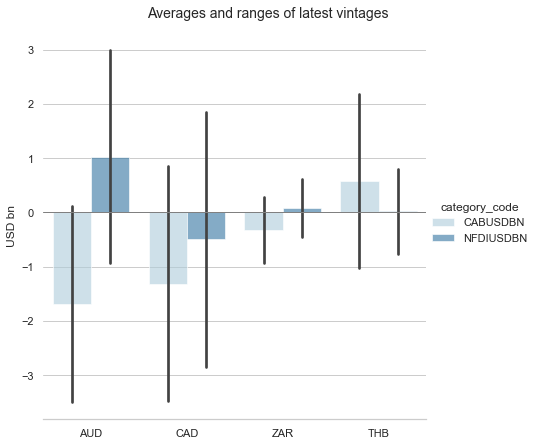

In [64]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in dfm.ticker.unique():
    dfm_x = dfm[dfm['ticker'] == tick]
    dfm_xx = dfm_x[dfm_x['release_date'] == dfm_x['release_date'].max()]
    indices = indices + dfm_xx.index.tolist()
dfg = dfm.iloc[indices, :]

# Barplot with sd vertical lines
sns.set(style="whitegrid")
g = sns.catplot(
    data=dfg, kind="bar",
    x="cross_section", y="value", hue="category_code",
    ci="sd", palette="Paired", alpha=.6, height=6
)
g.despine(left=True)
g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
g.fig.suptitle('Averages and ranges of latest vintages', y = 1.03, fontsize=14)
g.set_axis_labels("", "USD bn")
plt.show()

Box-whisker plots for quantitatively comparable categories across sections.

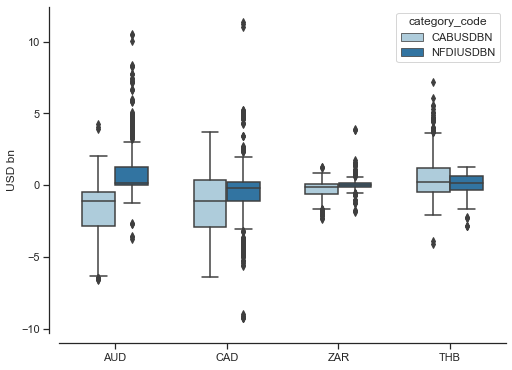

In [65]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in dfm.ticker.unique():
    dfm_x = dfm[dfm['ticker'] == tick]
    dfm_xx = dfm_x[dfm_x['release_date'] == dfm_x['release_date'].max()]
    indices = indices + dfm_xx.index.tolist()
dfg = dfm.iloc[indices, :]

# Nested boxplot
sns.set(rc={'figure.figsize':(8, 6)})  # set axis plot size
sns.set(style="ticks", palette="Paired")  
g = sns.boxplot(data=dfg,
            x="cross_section", y="value", hue="category_code",
            width=0.6)
sns.despine(offset=10, trim=False)
g.set(xlabel='', ylabel='USD bn')
plt.show()

Conditional means of different categories across sections (alternative to boxplot)

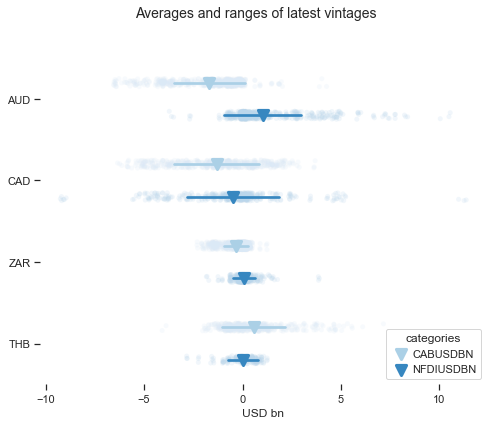

In [68]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in dfm.ticker.unique():
    dfmx = dfm[dfm['ticker'] == tick]
    dfmxx = dfmx[dfmx['release_date'] == dfmx['release_date'].max()]
    indices = indices + dfmxx.index.tolist()
dfm_g = dfm.iloc[indices, :]

f, ax = plt.subplots()
sns.set(style="ticks", palette = 'Blues')  
sns.despine(bottom=True, left=True)
sns.stripplot(data=dfm_g, # Show each observation with a scatterplot
              x="value", y="cross_section", hue="category_code",
              dodge=True, alpha=.2, zorder=1)
sns.pointplot(data=dfm_g,  # Show the conditional means
              x="value",  y="cross_section", hue="category_code",
              dodge=.4, join=False, palette='Blues',
              markers="v", scale=1.5, alpha=1, ci='sd')
f.suptitle('Averages and ranges of latest vintages', y = 1, fontsize=14)
ax.set(xlabel='USD bn', ylabel='')
handles, labels = ax.get_legend_handles_labels()  # refers to labels of strip- and pointplots
ax.legend(handles[2:], labels[2:], title="categories",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=1, frameon=True)
plt.show()

Two-dimensional histogram grid using generic FacetGrid/map methods

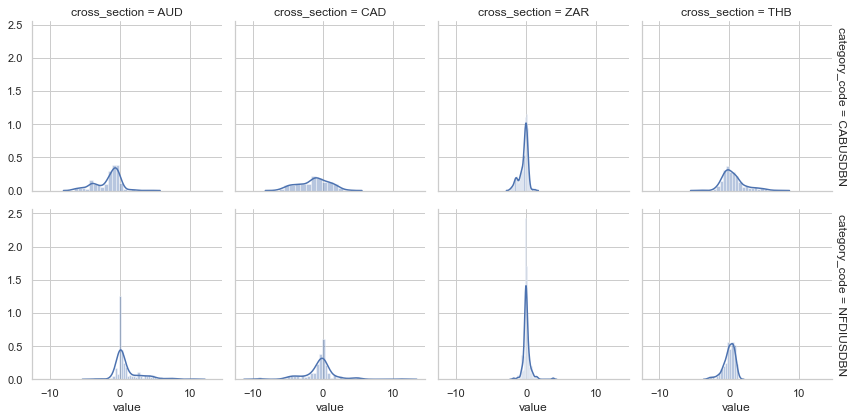

In [17]:
indices = []
for tick in dfm.ticker.unique():
    dfm_x = dfm[dfm['ticker'] == tick]
    dfm_xx = dfm_x[dfm_x['release_date'] == dfm_x['release_date'].max()]
    indices = indices + dfm_xx.index.tolist()
dfm_g = dfm.iloc[indices, :][['cross_section', 'category_code', 'observation_date', 'value']].reset_index(drop=True)
g = sns.FacetGrid(dfm_g, col='cross_section', row='category_code', margin_titles=True)
g.map(sns.distplot, 'value')
plt.show()

Two-dimensional histogram using displot shortcut.

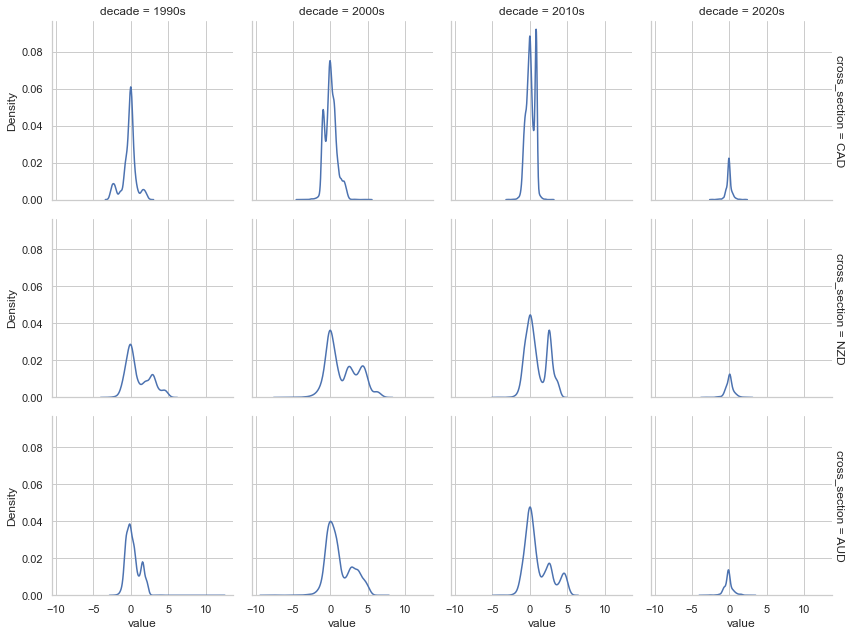

In [72]:
dfd_x = dfd[dfd['cross_section'].isin(['AUD', 'CAD', 'NZD'])]
dfd_x['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_x['observation_date']).year//10)]
sns.set_theme(style="whitegrid")
sns.displot(
    data=dfd, x="value", kind='kde',
    col="decade", row="cross_section",
    height=3, facet_kws=dict(margin_titles=True),
)
plt.show()

Two-dimensional grid of violinplots using factorplot method.

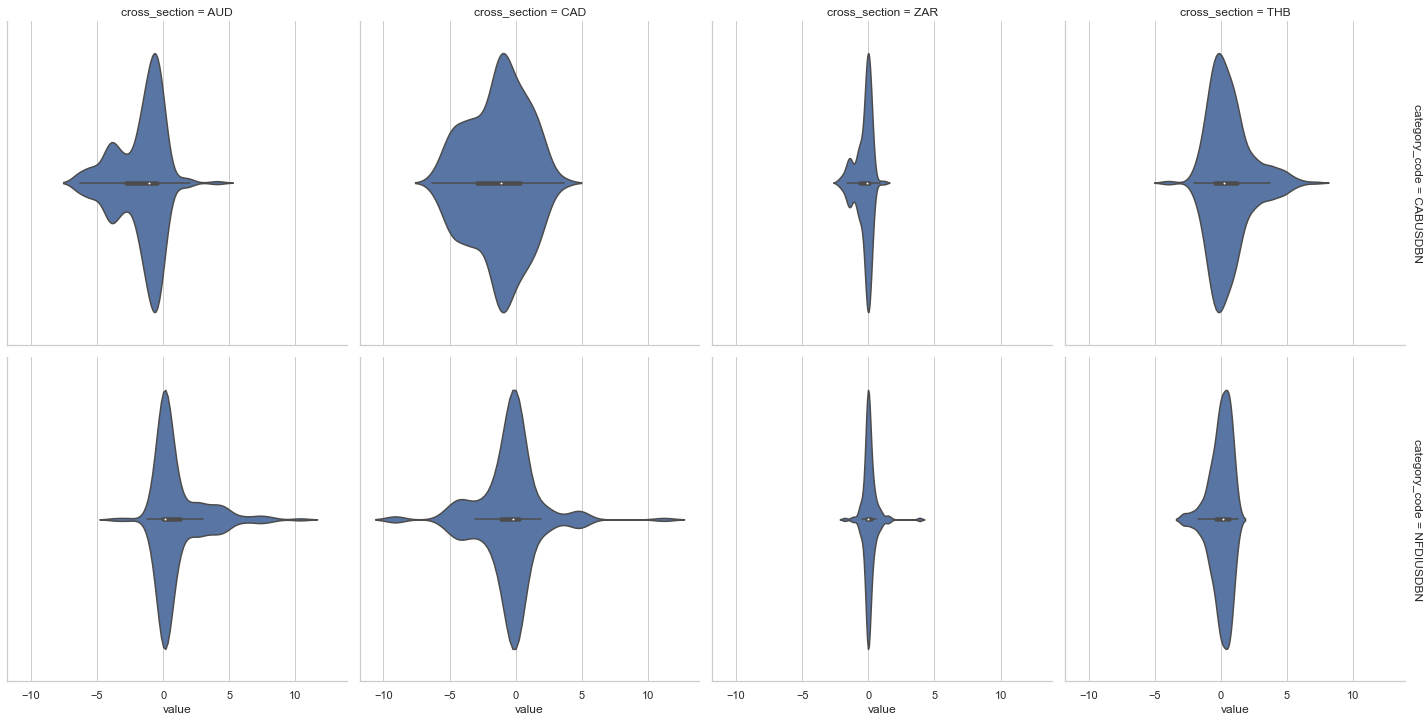

In [23]:
indices = []
for tick in dfm.ticker.unique():
    dfm_x = dfm[dfm['ticker'] == tick]
    dfm_xx = dfm_x[dfm_x['release_date'] == dfm_x['release_date'].max()]
    indices = indices + dfm_xx.index.tolist()
dfm_g = dfm.iloc[indices, :][['cross_section', 'category_code', 'observation_date', 'value']].reset_index(drop=True)
sns.factorplot(x="value", data=dfm_g, kind='violin', 
               col='cross_section', row='category_code', margin_titles=True)
plt.show()

Single histogram

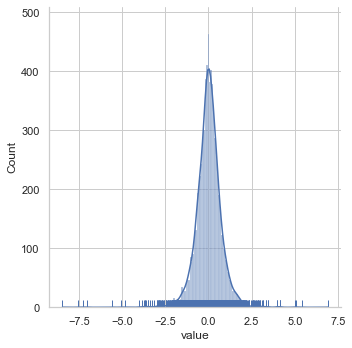

In [73]:
tick = 'AUD_FXXRUSD_NSA'
dfd_x = dfd[dfd['ticker'] == tick]
sns.displot(dfd_x['value'], kde=True, rug=True)
plt.show()

## Relational plots

Cross-correlation heatmap for single category across sections.

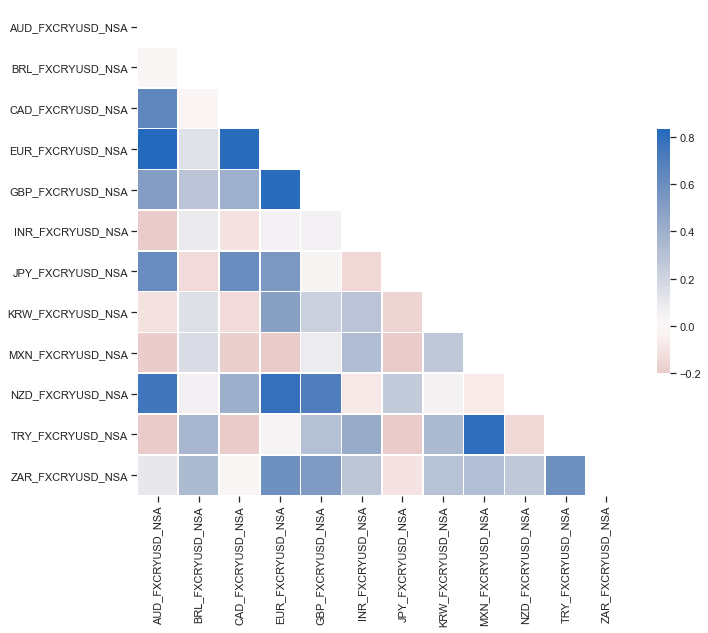

In [70]:
dfd_x = dfd[dfd['category_code'] == 'FXCRYUSD']
dfd_xw = dfd_x.pivot(index='observation_date', columns='ticker', values = 'value')

sns.set(style="ticks")  
corr = dfd_xw.corr()  # compute correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
f, ax = plt.subplots(figsize=(11, 9))  # set up figure

sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(xlabel='', ylabel='')
plt.show()

Facet of regression plots across time.

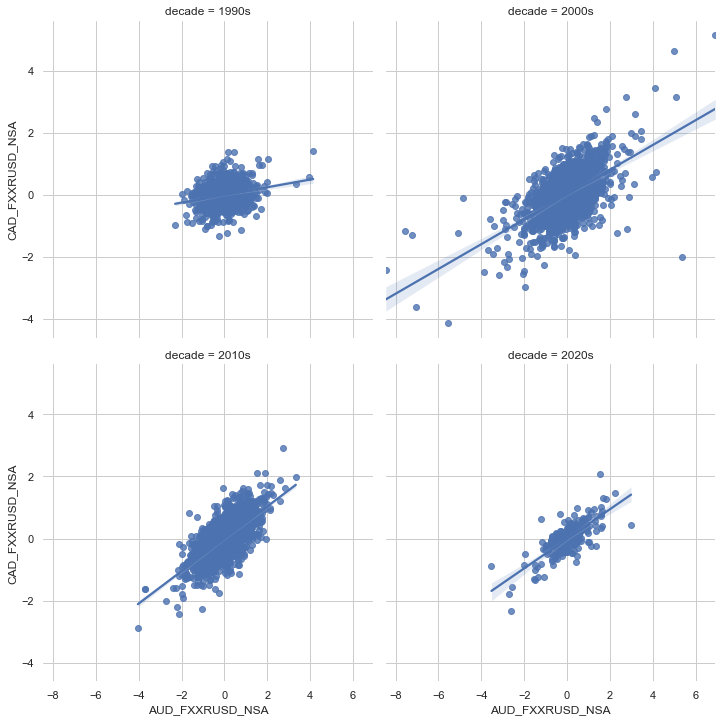

In [74]:
dfd_x = dfd[dfd['category_code'] == 'FXXRUSD']
dfd_xw = dfd_x.pivot(index='observation_date', columns='ticker', values = 'value')
dfd_xw['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_xw.index).year//10)]

sns.set(style="whitegrid")
sns.lmplot(data=dfd_xw, x='AUD_FXXRUSD_NSA', y='CAD_FXXRUSD_NSA', x_ci = 'ci', col='decade', col_wrap=2)
sns.despine(left=True, bottom=True)
plt.show()

Pairplot of relation across one category

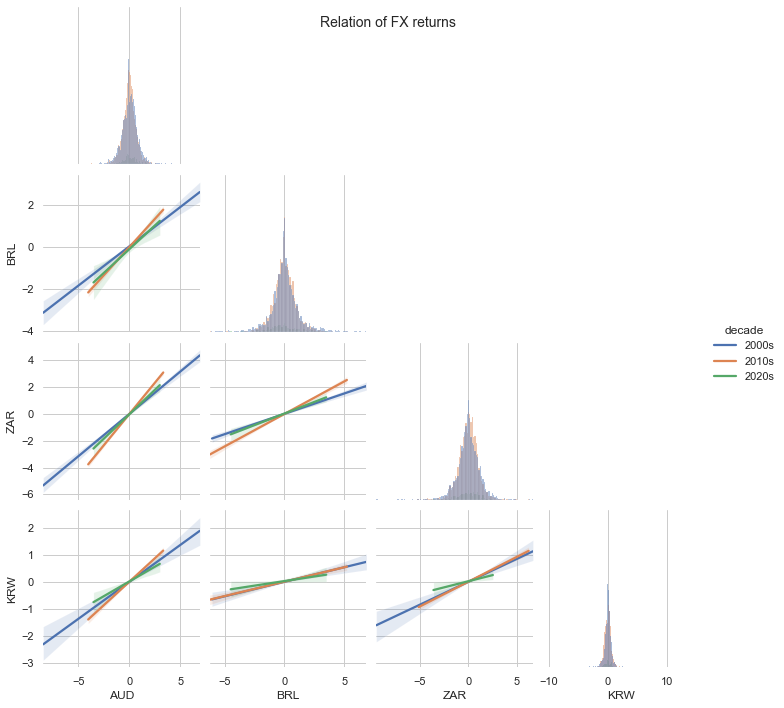

In [54]:
dfd_x = dfd[(dfd['category_code'] == 'FXXRUSD') & (dfd['observation_date'] >= pd.to_datetime('2000-01-01'))]
dfd_xw = dfd_x.pivot(index='observation_date', columns='cross_section', values = 'value')
dfd_xw['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_xw.index).year//10)]

sns.set(style="whitegrid")
g = sns.pairplot(dfd_xw, vars=['AUD', 'BRL', 'ZAR', 'KRW'], kind='reg', diag_kind='hist', corner=True,
             plot_kws={'scatter_kws': {'alpha': 0.4}, 'scatter': False},  # plot-specific keywords can be nested
             hue='decade')
sns.despine(left=True, bottom=True)
g.fig.suptitle('Relation of FX returns', y = 0.97, fontsize=14)
plt.show()

Scatter relation over two types of categorical valiables,

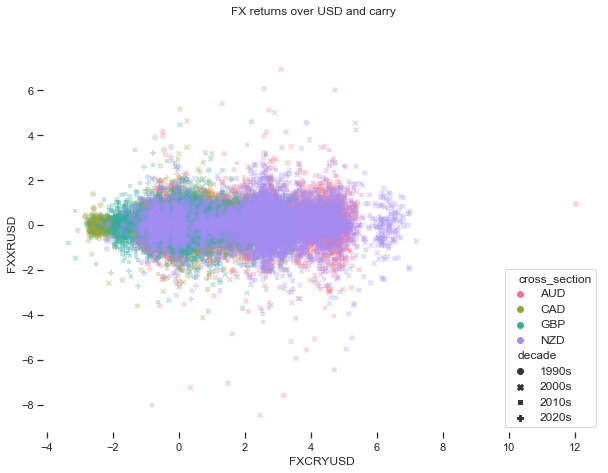

In [71]:
dfd_xw = dfd.loc[:, ['cross_section', 'category_code', 'observation_date', 'val
                     ue']]
dfd_xw = dfd_xw[dfd_xw['cross_section'].isin(['AUD', 'CAD', 'GBP', 'NZD'])]
dfd_xw.set_index(['cross_section', 'category_code', 'observation_date'], inplace=True)
dfd_xw = dfd_xw.unstack(1).reset_index()
dfd_xw['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_xw['observation_date']).year//10)]
dfd_xw.columns = ['cross_section', 'observation_date', 'FXCRYUSD', 'FXXRUSD', 'decade']
dfd_xw.tail()

f, ax = plt.subplots(figsize=(10, 7))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVxS2", "VVS1", "IF"]
sns.scatterplot(x='FXCRYUSD', y='FXXRUSD',
                style="decade", hue="cross_section",
                palette="husl",
                linewidth=0,
                alpha=0.3,
                data=dfd_xw, ax=ax)
f.sxuptitle('FX returns over USD and carry', y = 0.97, fontsize=12)
plt.show()

Hexbin plot with marginal distributions of two series. Best for ad-hoc comparisons.

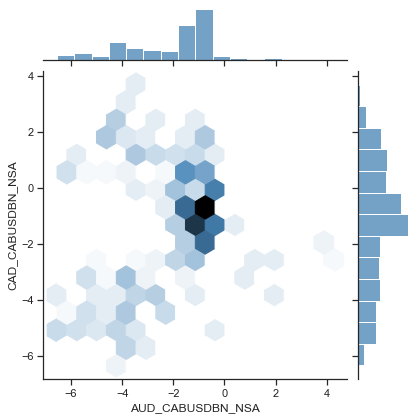

In [66]:
# Extract reduced dataframe with last release_dates for each ticker only
indices = []
for tick in dfm.ticker.unique():
    dfm_x = dfm[dfm['ticker'] == tick]
    dfm_xx = dfm_x[dfm_x['release_date'] == dfm_x['release_date'].max()]
    indices = indices + dfm_xx.index.tolist()
dfm_g = dfm.iloc[indices, :][['ticker', 'observation_date', 'value']].reset_index(drop=True)
dfm_g_w = dfm_g.pivot(index='observation_date', columns = 'ticker', values = 'value')

# Hexbin plot with marginal distributions of two series
sns.jointplot(data=dfm_g_w,kind="hex",
              x='AUD_CABUSDBN_NSA', y='CAD_CABUSDBN_NSA', 
              color="steelblue")
plt.show()